<a href="https://colab.research.google.com/github/airsresincrop/AIRS/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download Dataset (only have to run once per dataset per runtime)
Dataset = "AIRS_1024" #@param ["AIRS_128", "AIRS_256", "AIRS_512", "AIRS_1024", "AIRS_2048", "AIRS_4096", "AIRS_8192", "AIRS_10000"]
link_dict = {
  'AIRS_128': 'https://drive.google.com/uc?id=1jcQtXg8bYzTlgCMcxDqEYuC62j1XKf3t',
  'AIRS_256': 'https://drive.google.com/uc?id=1MohUSBykyDu94E1PTRelC5h0dA-LuuU1',
  'AIRS_512': 'https://drive.google.com/uc?id=1rxR0XTiDbPeJg88WLZctzPwuL9JquC4g',
  'AIRS_1024': 'https://drive.google.com/uc?id=1-5BDBZL8Tsxzi_wshN3d_EF6Zhn2iitY',
  'AIRS_2048': 'https://drive.google.com/uc?id=1a5A8xat3wJmEx11ml1UUqhTjMKbMFkG9',
  'AIRS_4096': 'https://drive.google.com/uc?id=1-F3N0NBorYSIikB_my4NY8t8NI2NAjk6',
  'AIRS_8192': 'https://drive.google.com/uc?id=1-2p-z1L2CWI-dr0EDj-9Ve5MXGBurEQI',
  'AIRS_10000': 'https://drive.google.com/uc?id=1-CsjdU3xVDiIuWQ0s95vKC9ceT6a7Vmb'
}

dataset_link = link_dict[Dataset]

print('Installing Tensorboard...')
!pip install -q -U tensorboard
print('Downloading Dataset...')
!gdown -q {dataset_link}
print('Unzipping Dataset...')
!unzip -qq {Dataset}.zip
print('Deleting Dataset zip...')
!rm {Dataset}.zip

# !gdown https://drive.google.com/uc?id=1jcQtXg8bYzTlgCMcxDqEYuC62j1XKf3t # AIRS_128.zip
# !gdown https://drive.google.com/uc?id=1MohUSBykyDu94E1PTRelC5h0dA-LuuU1 # AIRS_256.zip
# !gdown https://drive.google.com/uc?id=1rxR0XTiDbPeJg88WLZctzPwuL9JquC4g # AIRS_512.zip
# !gdown https://drive.google.com/uc?id=1-5BDBZL8Tsxzi_wshN3d_EF6Zhn2iitY # AIRS_1024.zip
# !gdown https://drive.google.com/uc?id=1a5A8xat3wJmEx11ml1UUqhTjMKbMFkG9 # AIRS_2048.zip
# !gdown https://drive.google.com/uc?id=1-F3N0NBorYSIikB_my4NY8t8NI2NAjk6 # AIRS_4096.zip
# !gdown https://drive.google.com/uc?id=1-2p-z1L2CWI-dr0EDj-9Ve5MXGBurEQI # AIRS_8192.zip
# !gdown https://drive.google.com/uc?id=1-CsjdU3xVDiIuWQ0s95vKC9ceT6a7Vmb # AIRS_10000.zip

Installing Tensorboard...
Unzipping Dataset...
Deleting Dataset zip...


In [0]:
# Import libraries
import tensorflow as tf
import os
import time
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from IPython import display

In [3]:
#@title Curate Dataset for TF (tick curate_dataset only during first run then untick)
resized_size = "1024" #@param {type:"string"}
dataset = "crop_512" #@param {type:"string"}
curate_dataset = True #@param {type:"boolean"}
if curate_dataset:
  print('Curating Dataset...')
  for split in ['train','val','test']:
    images = files = [f[:-4] for f in os.listdir(f'full_data/AIRS_{resized_size}/{dataset}/{split}/images/') if 'jpg' in f]
    Path(f'AIRS_{resized_size}/{dataset}/{split}').mkdir(parents = True, exist_ok = True)
    for f in tqdm(images, desc = split):
      img = plt.imread(f'full_data/AIRS_{resized_size}/{dataset}/{split}/images/{f}.jpg')
      lbl = plt.imread(f'full_data/AIRS_{resized_size}/{dataset}/{split}/labels/{f}.tif')*255
      stack = np.concatenate([img, lbl],axis=1)
      plt.imsave(f'AIRS_{resized_size}/{dataset}/{split}/{f}.png',stack)

Curating Dataset...


## Run from here everytime you train on the same dataset

In [0]:
#@title Choose supplementary loss for Generator
GEN_LOSS_CHOICE = "L1 Loss" #@param ["L1 Loss", "L2 Loss", "Soft Dice Loss"]
LAMBDA =  100#@param {type:"integer"}

In [0]:
# Helper Functions 
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)[:,:,:3]

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, w:, 0]
  input_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  real_image = tf.stack([255-real_image,real_image],axis=-1)

  return input_image, real_image

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  real_image = tf.concat([real_image,real_image[:,:,:1]],axis=-1)
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1][:,:,:2]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator(factor=1):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])

  down_stack = [
    downsample(64//factor, 3, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128//factor, 3), # (bs, 128, 128, 128)
    downsample(256//factor, 3), # (bs, 64, 64, 256)
    downsample(512//factor, 3), # (bs, 32, 32, 512)
    downsample(512//factor, 3), # (bs, 16, 16, 512)
    downsample(512//factor, 3), # (bs, 8, 8, 512)
    downsample(512//factor, 3), # (bs, 4, 4, 512)
    downsample(512//factor, 3), # (bs, 2, 2, 512)
    downsample(512//factor, 3), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512//factor, 3, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512//factor, 3, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(512//factor, 3), # (bs, 32, 32, 1024)
    upsample(256//factor, 3), # (bs, 64, 64, 512)
    upsample(128//factor, 3), # (bs, 128, 128, 256)
    upsample(64//factor, 3), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='softmax') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  if GEN_LOSS_CHOICE == 'L1 Loss':
    # mean absolute error
    loss = tf.reduce_mean(tf.abs(target - gen_output))
    loss_name = 'gen_l1_Loss'
  elif GEN_LOSS_CHOICE == 'L2 Loss':
    # mean square error
    loss = tf.reduce_mean(tf.square(target - gen_output))
    loss_name = 'gen_l2_Loss'
  elif GEN_LOSS_CHOICE == 'Soft Dice Loss':
    # soft dice loss
    numerator = tf.reduce_sum(target * gen_output,axis=[1,2])
    denominator = tf.reduce_sum(tf.square(target) + tf.square(gen_output), axis=[1,2])
    loss = 1 - tf.reduce_mean(numerator / (denominator + 1e-6))
    loss_name = 'gen_dice_loss'

  total_gen_loss = gan_loss + (LAMBDA * loss)

  return total_gen_loss, gan_loss, loss, loss_name

def Discriminator(factor=1):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(64//factor, 3, False)(x) # (bs, 256, 256, 64)
  down2 = downsample(128//factor, 3)(down1) # (bs, 128, 128, 128)
  down3 = downsample(256//factor, 3)(down2) # (bs, 64, 64, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 66, 66, 256)
  conv = tf.keras.layers.Conv2D(512//factor, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 63, 63, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 65, 65, 512)

  last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 62, 62, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)

  pred = np.array(tf.argmax(prediction[0],axis=-1))
  t = np.array(tf.argmax(tar[0],axis=-1))
  fore_inter = np.logical_and(pred,t).sum()
  fore_union = np.logical_or(pred,t).sum()
  back_inter = np.logical_and(1-pred,1-t).sum()
  back_union = np.logical_or(1-pred,1-t).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], t, pred]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  print(f'mIoU for this example: {miou}')

def get_miou(model, dataset, dataset_length):
  preds = np.zeros((dataset_length,IMG_HEIGHT,IMG_WIDTH),dtype = np.uint8)
  ts = np.zeros((dataset_length,IMG_HEIGHT,IMG_WIDTH),dtype = np.uint8)
  count = 0
  for inp, tar in dataset.take(dataset_length):
    prediction = model(inp, training=False)
    pred = np.array(prediction[0]).argmax(axis=-1)
    t = np.array(tar[0]).argmax(axis=-1)
    preds[count] = pred
    ts[count] = t
    count += 1
  fore_inter = np.logical_and(preds,ts).sum()
  fore_union = np.logical_or(preds,ts).sum()
  back_inter = np.logical_and(1-preds,1-ts).sum()
  back_union = np.logical_or(1-preds,1-ts).sum()
  miou = (fore_inter/fore_union + back_inter/back_union)/2
  print(f'mIoU: {miou}')
  return preds, ts, miou

In [6]:
# Parameters
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = int(resized_size)
IMG_HEIGHT = IMG_WIDTH
CROP = dataset.split('_')[1]
if CROP is not 'full':
  IMG_WIDTH = int(CROP)
  IMG_HEIGHT = IMG_WIDTH
print("IMG_WIDTH: "+str(IMG_WIDTH),",","IMG_HEIGHT: "+str(IMG_HEIGHT))
PATH = f'AIRS_{resized_size}/{dataset}/' # Change as per dataset
gen_factor = 1
disc_factor = 1
OUTPUT_CHANNELS = 2
EPOCHS = 100

IMG_WIDTH: 512 , IMG_HEIGHT: 512


In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 572 x 572 x 3
  input_image, real_image = resize(input_image, real_image, int(1.1171875*IMG_WIDTH), int(1.1171875*IMG_HEIGHT))

  # randomly cropping to 512 x 512 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [0]:
import matplotlib as mpl
mpl.rc('image', cmap='gray')

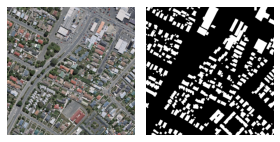

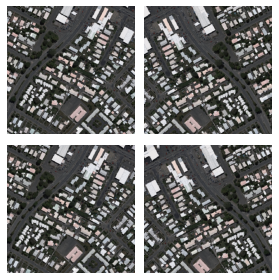

In [9]:
inp, re = load(PATH+'train/99.png')
# casting to int for matplotlib to show the image
fig = plt.figure(figsize=(4,4))
plt.subplot(121)
plt.imshow(inp/255.0)
plt.axis('off')
plt.tight_layout()
plt.subplot(122)
plt.imshow(tf.argmax(re,-1)/255)
plt.axis('off')
plt.tight_layout()
fig = plt.figure(figsize=(4, 4))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.imshow(tf.argmax(rj_re,-1)/255, alpha=0.5)
  plt.axis('off')
fig.tight_layout()

In [10]:
# Create TF dataset
train_dataset = tf.data.Dataset.list_files(PATH+'val/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset_length = len(list(train_dataset))

val_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset_length = len(list(val_dataset))

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(list(test_dataset))

print(train_dataset_length, val_dataset_length, test_dataset_length)

80 400 80


In [11]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)
(1, 512, 512, 3)


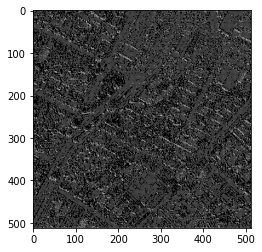

In [12]:
# Create Generator
generator = Generator(factor=gen_factor)
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(tf.argmax(gen_output[0],-1))

Text(0.5, 1.0, 'Ground truth input')

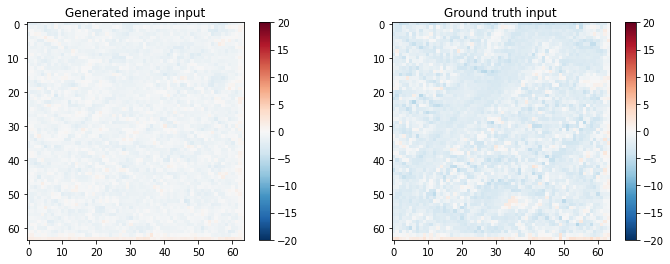

In [13]:
# Create Discriminator
plt.figure(figsize=(12,4))
plt.subplot(121)
discriminator = Discriminator(disc_factor)
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.title('Generated image input')
plt.subplot(122)
disc_out = discriminator([inp[tf.newaxis,...], re[tf.newaxis,...]], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.title('Ground truth input')

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_loss, gen_loss_name = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar(gen_loss_name, gen_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_ds, val_ds, val_dataset_length, epochs, test_ds):
  best_miou = 0
  for example_input, example_target in test_ds.take(1):
    continue
  for epoch in range(epochs):
    start = time.time()
    
    display.clear_output(wait=True)
    generate_images(generator, example_input, example_target)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # Validate
    _, _, miou = get_miou(generator, val_ds, val_dataset_length)
    print(f'Validation mIoU: {miou:.4f}')
    with summary_writer.as_default():
      tf.summary.scalar('val_miou', miou, step=epoch)
    if miou > best_miou:
      print('Best mIoU so far, saving checkpoint')
      manager.save()
      best_miou = miou

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [17]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

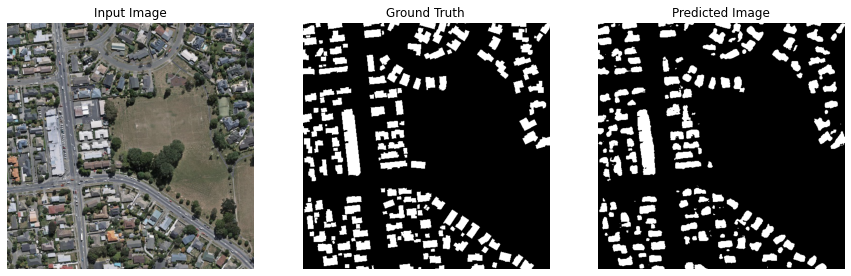

mIoU for this example: 0.8365403502904131
................................................................................


In [0]:
fit(train_dataset, val_dataset, val_dataset_length, EPOCHS, test_dataset)

### Evaluation

In [64]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [65]:
print(f'gen_factor: {gen_factor}, disc_factor: {disc_factor}, lambda: {LAMBDA}, loss: {GEN_LOSS_CHOICE}')
print('Training')
_, _, _ = get_miou(generator, train_dataset, train_dataset_length)
print('Validating')
_, _, _ = get_miou(generator, val_dataset, val_dataset_length)
print('Testing')
_, _, _ = get_miou(generator, test_dataset, test_dataset_length)

gen_factor: 1, disc_factor: 1, lambda: 0, loss: L1 Loss
Training
mIoU: 0.39714844224793516
Validating
mIoU: 0.4131812345807595
Testing
mIoU: 0.3778239256726823
